# Introduction

![banner.png](attachment:f3d272ef-b2a9-4401-a882-cc433bcb06c6.png)

**Credits:**
I would like to give credits to below Kaggle notebooks and Kornia official website tutorials,
1. [Whales feature matching LoFTR - Kornia](https://www.kaggle.com/code/remekkinas/whales-feature-matching-loftr-kornia)  by @remekkinas
1. [IMC 2022-kornia LoFtr from 0.533 to 0.721](https://www.kaggle.com/code/ammarali32/imc-2022-kornia-loftr-from-0-533-to-0-721) by @ammarali32
1. https://kornia-tutorials.readthedocs.io/en/latest/image_matching.html
1. https://zju3dv.github.io/loftr/

To solve this problem, we will be using LoFTR method in Kornia library

## Kornia:
Kornia is a differentiable library that allows classical computer vision to be integrated into deep learning models.
![kornia_banner_pixie.png](attachment:8422301f-5f7c-41fd-9002-4cb145968cd5.png)

It consists of a set of routines and differentiable modules to solve generic computer vision problems. At its core, the package uses PyTorch as its main backend both for efficiency and to take advantage of the reverse-mode auto-differentiation to define and compute the gradient of complex functions.

Some key usecases of Kornia are,
* Data Augmentation
* Image matching(with LoFTR. We will be using it)
* Image stitching
* Face Detection
* Denoise image

**LoFTR:**
LoFTR is a method for local image feature matching. 
* This method first establish pixel-wise dense matches at a coarse level 
* Later refine the good matches at a fine level. 
* It uses self and cross attention layers in Transformers to obtain feature descriptors that are conditioned on both images.


The global receptive field provided by Transformers enables our method to produce dense matches in low-texture areas, where feature detectors usually struggle to produce repeatable interest points. 
The experiments on indoor and outdoor datasets show that LoFTR outperforms state-of-the-art methods by a large margin.
For our problem we can use outdoor dataset.

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'aSCPD/CS231N/Project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/aSCPD/CS231N/Project


In [2]:
dry_run = False
!pip install kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
!pip install kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl


In [3]:
import matplotlib.pyplot as plt
import cv2
import csv
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
from kornia_moons.feature import *
import gc

In [4]:
src = 'image-matching-challenge-2022/'

In [5]:
device = torch.device('cuda')
matcher = KF.LoFTR(pretrained=None)
matcher.load_state_dict(torch.load("kornia-loftr/loftr_outdoor.ckpt")['state_dict'])
matcher = matcher.to(device).eval()

In [6]:
def load_torch_image(fname,device):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img)
    return img.to(device)

In [14]:
def image_match(batch_id, img1_id, img2_id):
    img1 = load_torch_image(f'{src}/test_images/{batch_id}/{img1_id}.png',device)
    img2 = load_torch_image(f'{src}/test_images/{batch_id}/{img2_id}.png',device)
        
    input_dict = {"image0": K.color.rgb_to_grayscale(img1), 
                  "image1": K.color.rgb_to_grayscale(img2)}
    
    with torch.no_grad():
        correspondences = matcher(input_dict)
    
    mkpts0 = correspondences['keypoints0'].cpu().numpy()
    mkpts1 = correspondences['keypoints1'].cpu().numpy()
    
    if len(mkpts0) > 7:
        H, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.FM_RANSAC, 0.1, 0.999, 100000) #USAC_ACCURATE, cv2.USAC_MAGSAC
        inliers = inliers > 0
        assert H.shape == (3, 3), 'Malformed F?'
        
    else:
        H = np.zeros((3, 3))
        
    gc.collect()    
    
    draw_LAF_matches(
    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
    torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={'inlier_color': (0.2, 1, 0.2),
               'tentative_color': None, 
               'feature_color': (0.2, 0.5, 1), 'vertical': False})
    return H

In [8]:
test_dt = []
with open(f'{src}/test.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for i, row in enumerate(reader):
        if i == 0: #Ignoring header
            continue
        test_dt += [row]

In [10]:
pip install opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/kornia/feature/loftr/utils/coarse_matching.py:255: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
/usr/local/lib/python3.7/dist-packages/kornia/feature/loftr/utils/coarse_matching.py:258: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % 

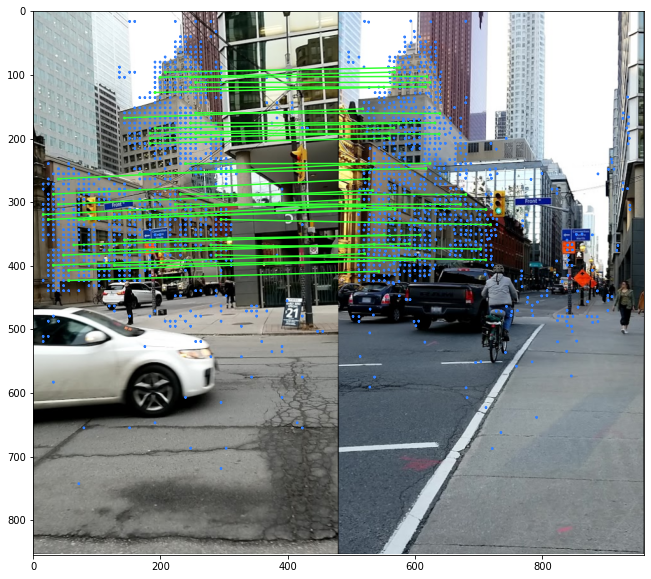

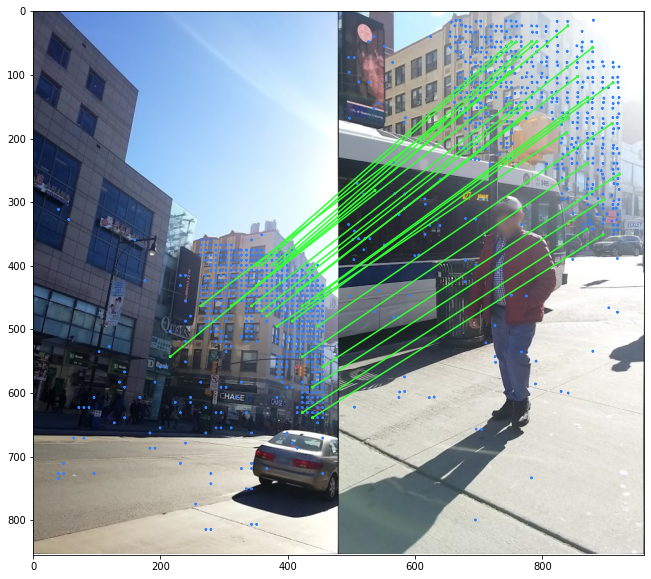

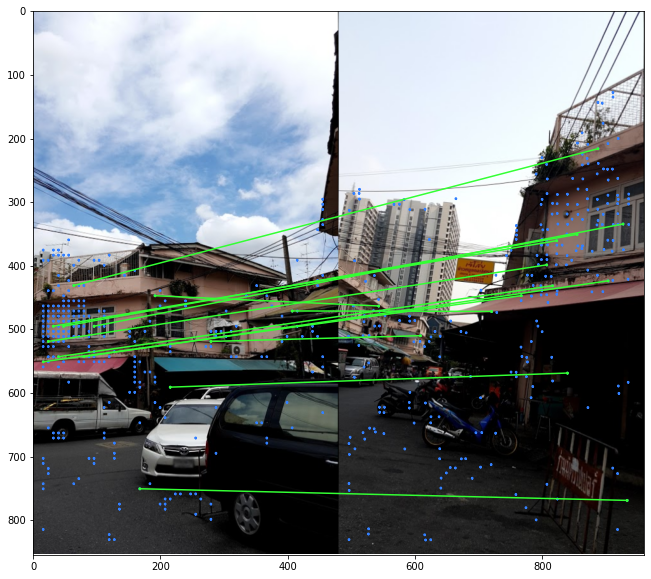

In [15]:
F_dict = {}
import time
for i, row in enumerate(test_dt):
    sample_id, batch_id, image_1_id, image_2_id = row
    H = image_match(batch_id,image_1_id,image_2_id)
    F_dict[sample_id] = H

## Evaluation metric
We need to estimate the relative pose of one image with respect to another. Submissions are evaluated on the **mean Average Accuracy (mAA)** of the estimated poses. Given a fundamental matrix and the hidden ground truth, we compute the error in terms of rotation (in degrees) and translation (in meters).
Given one threshold over each, we classify a pose as accurate if it meets both thresholds. 
This will be done the over ten pairs of thresholds, one pair at a time (e.g. at 1 and 20 cm at the finest level, and 10 and 5 m at the coarsest level):

In [16]:
with open('submission.csv', 'w') as f:
    f.write('sample_id,fundamental_matrix\n')
    for sample_id, F in F_dict.items():
        M = ' '.join([f'{v:.{8}e}' for v in F.flatten()])
        f.write(f'{sample_id},{M}\n')